In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from src.models.components.mlp import MyMLPTemperature, MyMLP

import torch
import torchsde
from torch import vmap
from torchdiffeq import odeint

from src.energies.gmm_energy import GMM, GMMTempWrapper
from fab.target_distributions import gmm

from src.energies.base_prior import Prior, MeanFreePrior

from src.models.components.clipper import Clipper

from torch.func import hessian
from math import sqrt
from src.utils.data_utils import remove_mean
from math import sqrt, log

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [4]:
dimensionality = 2
temperature = 1.0
annealed_temperature = 1/2
inverse_temperature = temperature / annealed_temperature # beta in the paper

target = GMM(dimensionality=dimensionality,
             n_mixes=40,
             loc_scaling= 40.0,
             log_var_scaling=2.0,
             device=device,
             should_unnormalize=True,
             )

annealed_target = GMMTempWrapper(target, beta=int(inverse_temperature))

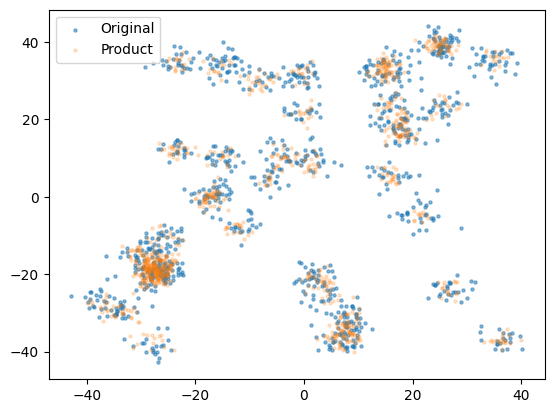

In [5]:
a = target.sample_test_set(1000)
b = annealed_target.sample_test_set(1000)

plt.scatter(a[:, 0].detach().cpu(), a[:, 1].detach().cpu(), label="Original", alpha=0.5, s=5)
plt.scatter(b[:, 0].detach().cpu(), b[:, 1].detach().cpu(), label="Product", alpha=0.2, s=5)
# plt.scatter(annealed_target.gmm.locs[:, 0].cpu(),annealed_target.gmm.locs[:, 1].cpu(), label="Means", s=20)
plt.legend()

In [6]:
modes = torch.stack([target.gmm.locs[10],
                     target.gmm.locs[20], 
                     target.gmm.locs[18]])

scales = torch.stack([target.gmm.scale_trils[10],
                      target.gmm.scale_trils[20], 
                      target.gmm.scale_trils[18]])


mix = torch.distributions.Categorical(logits=torch.ones(3).to(device))
com = torch.distributions.MultivariateNormal(modes,
                                             scale_tril=scales,
                                             validate_args=False)
two_mode_dist = torch.distributions.MixtureSameFamily(mixture_distribution=mix,
                                                      component_distribution=com,
                                                      validate_args=False)

In [7]:
one_mode_samples = torch.randn(1000, 2).to(device) * target.gmm.scale_trils[10][0,0] + target.gmm.locs[10][None, :].repeat(1000, 1)
init_samples = two_mode_dist.sample((1000,))

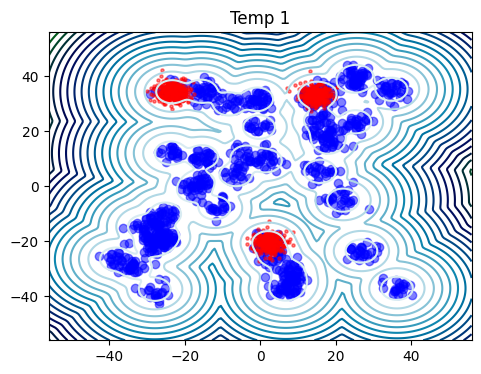

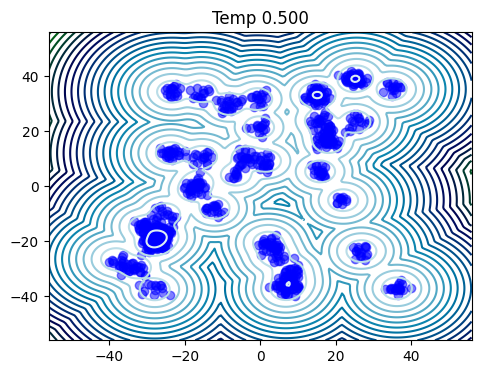

In [8]:
target.get_dataset_fig(a, title="Temp 1")
plt.scatter(init_samples[:, 0].detach().cpu(), init_samples[:, 1].detach().cpu(), c="r", label="One mode", alpha=0.5, s=5)
plt.show()

# title is annealed temperature up to 3 decimal points
annealed_target.get_dataset_fig(b, title=f"Temp {annealed_temperature:.3f}")
plt.show()

## Functions

In [9]:
from src.models.components.utils import rademacher, compute_laplacian_hutchinson
from src.models.components.utils import sample_cat_sys

In [ ]:
def true_Ut(target, x, t, noise_schedule, ve=True):
    h_t = noise_schedule.h(t).to(device)
    mean_coeff = None
    if not ve:
        mean_coeff = noise_schedule.log_mean(t).to(device)
    target.gmm.convolve(h_t * (target.data_normalization_factor**2), t, var_exploding=ve, mean_coeff=mean_coeff)
    energy = target(x)
    target.gmm.reset()
    return energy

In [ ]:
def true_nabla_Ut(target, x, t, noise_schedule, ve=True):
    nabla_Ut = torch.func.jacrev(true_Ut, argnums=1)(target, x, t, noise_schedule, ve)
    return nabla_Ut

In [ ]:
def compute_laplacian_exact(model, t, xt, beta):
    def func_wrap(t, xt):
        return model(t.unsqueeze(0), xt.unsqueeze(0), beta).squeeze()
    
    # Calculate the Hessian matrix of the model output with respect to the input
    hessian_matrix = vmap(hessian(func_wrap, argnums=1))(t, xt)

    # Calculate the Laplacian as the trace of the Hessian matrix
    laplacian = hessian_matrix.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    return laplacian.detach()


def compute_laplacian(model, nabla_Ut, t, xt, beta, n_samples=1, exact=True):
    if exact:
        return compute_laplacian_exact(model, t, xt, beta)
    else:
        laplacian = 0
        for _ in range(n_samples):
            laplacian += compute_laplacian_hutchinson(nabla_Ut, t, xt)
        return laplacian / n_samples

In [ ]:
class VEReverseSDE(torch.nn.Module):
    def __init__(self, model, noise_schedule, score_model=None):
        super().__init__()
        self.model = model
        self.score_model = score_model
        self.noise_schedule = noise_schedule

    def f(self, t, x, beta, resampling_interval=-1):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)
        
        with torch.enable_grad():
            x.requires_grad_(True)
            t.requires_grad_(True)
            
            epsilon_t = self.g(t).pow(2) / 2 
                            
            nabla_Ut = self.model(t, x, beta)

            drift_X = nabla_Ut * self.g(t).pow(2).unsqueeze(-1)

            drift_A = torch.zeros(x.shape[0]).to(x.device)

            if resampling_interval == -1:
                return  drift_X.detach(), drift_A.detach()
            
            Ut = self.model.forward_energy(t, x, beta)
            if self.score_model is not None:
                bt = epsilon_t * self.score_model(t, x, beta)
                div_bt = epsilon_t * torch.autograd.grad(bt.sum(), x, create_graph=True)[0]

            else:
                bt = epsilon_t[:, None] * nabla_Ut
                div_bt = epsilon_t * compute_laplacian(self.model.forward_energy, nabla_Ut,
                                                       t, x, beta, n_samples=None, exact=True)
            
            dUt_dt = torch.autograd.grad(Ut.sum(), t, create_graph=True)[0]
            drift_A = -div_bt - (nabla_Ut * bt).sum(-1) + dUt_dt

        return  drift_X.detach(), drift_A.detach()

    def g(self, t):
        g = self.noise_schedule.g(t)
        return g

### Integrators

In [ ]:
def euler_maruyama_step(
        sde: VEReverseSDE,
        t: torch.Tensor,
        x: torch.Tensor,
        a: torch.tensor, 
        dt: float,
        step: int,
        batch_size: int,
        diffusion_scale=1.0,
        resampling_interval=-1,
        inverse_temp=1.0,
):
    # Calculate drift and diffusion terms for num_eval_batches

    drift_Xt = torch.zeros_like(x)
    drift_At = torch.zeros_like(a)

    for i in range(x.shape[0]//batch_size):
        drift_Xt_i, drift_At_i = sde.f(t, x[i*batch_size:(i+1)*batch_size], inverse_temp, resampling_interval)
        drift_Xt[i*batch_size:(i+1)*batch_size] = drift_Xt_i
        drift_At[i*batch_size:(i+1)*batch_size] = drift_At_i

    # drift_Xt, drift_At = sde.f(t, x, resampling_interval)
    drift_Xt = drift_Xt * dt
    drift_At = drift_At * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones_like(x).to(x.device)
    diffusion = diffusion_scale * sde.g(t) * np.sqrt(dt) * torch.randn_like(x).to(x.device)

    # Update the state
    x_next = x + drift_Xt + diffusion
    a_next = a + drift_At

    if resampling_interval==-1 or step+1 % resampling_interval != 0:
        return x_next, a_next

    #resample based on the weights
    choice, _ = sample_cat_sys(x.shape[0], a_next)
    x_next = x_next[choice]
    a_next = torch.zeros_like(a_next)
    
    return x_next, a_next


def integrate_sde_coupled(sde, x0, t_span, dt, diffusion_scale,
                          resampling_interval, inverse_temp):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    a = torch.zeros(x.shape[0]).to(device)
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a = euler_maruyama_step(sde, 1-t, x, a, dt, step+1, 
                                       batch_size=x.shape[0], diffusion_scale=diffusion_scale,
                                       resampling_interval=resampling_interval, inverse_temp=inverse_temp)
            samples.append(x)
            logweights.append(a)
    return torch.stack(samples), torch.stack(logweights)

def generate_samples_weighted(reverse_sde, prior, num_samples=1000, t_span=(0, 1),
                              num_integration_steps=1000, samples=None, diffusion_scale=1.0,
                              resampling_interval=-1, inverse_temp=1):
    
    if samples is None:
        samples = prior.sample(num_samples)

    dt = 1 / num_integration_steps

    samples, weights = integrate_sde_coupled(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=dt,
        resampling_interval = resampling_interval,
        diffusion_scale=diffusion_scale,
        inverse_temp=inverse_temp,
    )
    return samples[-1], weights

### Model

In [ ]:
from torch import nn
class EnergyNet(nn.Module):
    def __init__(
        self, 
        score_net: nn.Module,
        target,
        betas,
        noise_schedule,
        prior = None
    ):
        super(EnergyNet, self).__init__()
        self.score_net = score_net
        self.prior = prior
        self.noise_schedule = noise_schedule
        self.energy_function = {}
        for beta in betas:
            self.energy_function[beta] = GMMTempWrapper(target, beta=beta)

        self.c = nn.Parameter(torch.tensor(0.0))

    def forward_energy(self, t: torch.Tensor, x: torch.Tensor, beta) -> torch.Tensor:
        # parametrize energy as <score_net(t, x), x>
        # U_1 = self.prior.log_prob(x)
        U_0 = target(x) * beta 
        U_0 = torch.clamp(U_0, max=1e3, min=-1e3)

        beta = beta * torch.ones(x.shape[0]).to(x.device)
        beta = beta.unsqueeze(1)


        h_t = self.noise_schedule.h(t).to(device)

        c_s = 1 / (1 + h_t)
        c_in = 1/ (1 + h_t)**0.5
        c_out = h_t**0.5 * c_in
        c_noise = 1/4 * torch.log(h_t)


        score = self.score_net(c_noise, c_in[:, None] * x, beta) 
        U_theta = torch.sum(score* x, dim=1)

        E_theta = (1 - c_s)/(2 * h_t) * torch.linalg.norm(score, dim=-1)**2 - c_out/(c_in * h_t) * U_theta
        # return E_theta

        return (1 - t)**3 * U_0 + t * E_theta

    def forward(self, t: torch.Tensor, x: torch.Tensor, beta) -> torch.Tensor:
        # beta = beta * torch.ones(x.shape[0]).to(x.device)
        # beta = beta.unsqueeze(1)
        # return self.score_net(t, x, beta)
        U = self.forward_energy(t, x, beta)
        nabla_U = torch.autograd.grad(U.sum(), x, create_graph=True)[0]
        return nabla_U

## Training

### Functions

In [ ]:
def score_loss(score_net, x, t, noise_schedule, beta):
    h_t = noise_schedule.h(t.unsqueeze(1))
    x.requires_grad = True

    z = torch.randn_like(x)
    xt = x + z * h_t ** 0.5

    s_pred = score_net(t, xt, beta)
    s_true = - z 
    s_diff =  torch.sum((s_pred * h_t ** 0.5 - s_true) ** 2, dim=(-1)) #* lambda_t
    return s_diff.mean()   

In [ ]:
from torchcfm.conditional_flow_matching import ConditionalFlowMatcher
from src.models.components.mlp import MyMLP
FM = ConditionalFlowMatcher(sigma=0.0)

def cfm_loss(model, x1, t, beta):
    h_t = noise_schedule.h(t.unsqueeze(1))
    x0 = torch.randn_like(x1)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(t, xt, beta)
    loss = torch.mean((vt - ut) ** 2)
    return loss

In [ ]:
def cfm_inference(model, xt, t, beta, dt):
    with torch.no_grad():
        vt = model(t * torch.ones(xt.shape[0]).to(device), xt, beta)
        xt_new = xt + vt * dt
        return xt_new

In [ ]:
def generate_samples_ode(model, prior, beta, n_samples=1000, t_span=[0,1], dt=0.001):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    samples = []
    x = prior.sample(n_samples)  
    with torch.no_grad():
        for t in times:
            x = cfm_inference(model, x, t, beta, 1e-3)
            samples.append(x)
    return torch.stack(samples)[-1]

### Loop

In [ ]:
from src.models.components.noise_schedules import GeometricNoiseSchedule, ElucidatingNoiseSchedule
noise_schedule = GeometricNoiseSchedule(sigma_min=0.001, sigma_max=10)
#noise_schedule = ElucidatingNoiseSchedule(sigma_min=0.002, sigma_max=80)

# betas = [1, 2, 3, 4]
betas=torch.arange(1, 5, 0.5)

In [100]:
priors = {}
for beta in betas:
    priors[beta] = Prior(2, device=device, scale = (noise_schedule.h(1) / beta) ** 0.5)

In [106]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = {}

for beta in betas:
    buffer[beta] = SimpleBuffer(
        2,
        10000,
        1000,
        initial_sampler=None,
        device=device,
        fill_buffer_during_init=False,
        sample_with_replacement=True,
        prioritize=False,
    )

Buffer not initialised, expected that checkpoint will be loaded.


In [107]:
outer_epochs= 100
inner_epochs = 400
batch_size = 1024


# init_samples = target.sample_test_set(10000)
init_samples_normalized = target.normalize(init_samples)
init_samples_energy = target(init_samples_normalized)

train_dataset = TensorDataset(init_samples_normalized.detach(), init_samples_energy.clone())
trainloader = {}

for beta in betas:
    trainloader[beta] = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

In [108]:
# def score_loss(model, x, t, noise_schedule, beta):
#     x.requires_grad = True
#     h_t = noise_schedule.h(t.unsqueeze(1))
    
#     # noisy sample: x(t)
#     xt = torch.normal(x, h_t**0.5)

#     pred_scores = model(t, xt, beta)

#     true_scores = - (xt - x)/ (h_t + 1e-3)
    
#     lambda_t = (h_t + 1e-3)
#     s_diff = lambda_t * torch.linalg.vector_norm(pred_scores - true_scores, dim=-1) ** 2
#     return s_diff.mean()    

In [109]:
score_net = MyMLPTemperature().to(device)
# score_net = MyMLP().to(device)
model = EnergyNet(score_net, target=target, betas=betas, noise_schedule=noise_schedule).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
weighted = False

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 1.292182
Epoch 99 | Loss 1.326994
Epoch 198 | Loss 1.416637
Epoch 297 | Loss 1.349511
Epoch 396 | Loss 1.322428


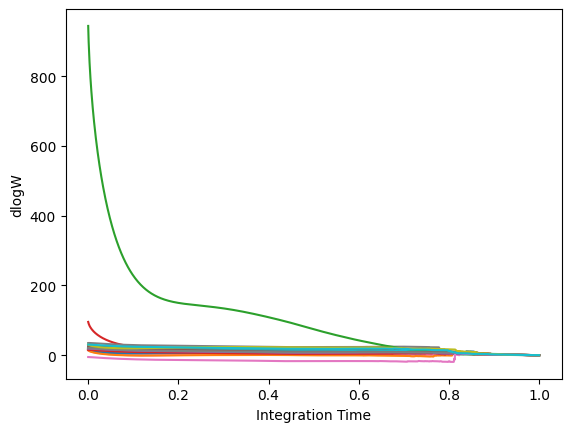

Mean of Energy tensor(-2212.7827, device='cuda:0')


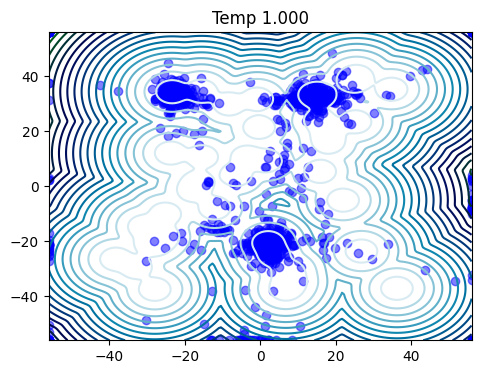

  1%|          | 1/100 [01:15<2:04:30, 75.46s/it]

Epoch 0 | Loss 1.344798
Epoch 99 | Loss 1.290296
Epoch 198 | Loss 1.320509
Epoch 297 | Loss 1.847675
Epoch 396 | Loss 1.269790


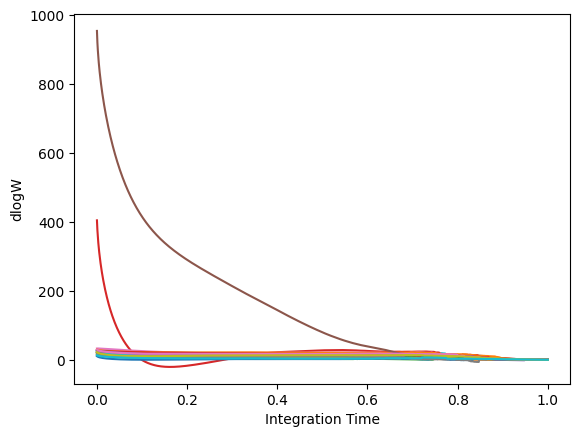

Mean of Energy tensor(-3160.4861, device='cuda:0')


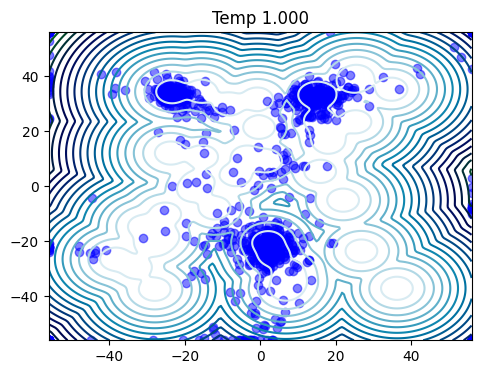

  2%|▏         | 2/100 [02:25<1:57:34, 71.98s/it]

Epoch 0 | Loss 1.322665
Epoch 99 | Loss 1.339937
Epoch 198 | Loss 1.464761
Epoch 297 | Loss 1.420148
Epoch 396 | Loss nan


In [111]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for beta in betas:
            for samples,_ in trainloader[beta]:
                samples = samples.to(device)
                
                optimizer.zero_grad()

                t = torch.rand(len(samples)).to(device)

                loss = score_loss(model, 
                                  samples,
                                  t, 
                                  noise_schedule,
                                  beta)
                # loss = cfm_loss(model,
                #                 samples,
                #                 t,
                #                 beta)
            
                total_loss += loss.item()
                loss.backward()
                optimizer.step()
                
            if epoch % 99 == 0:
                print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the network
    ve_reverse_sde = VEReverseSDE(model, noise_schedule)
    for beta in betas:
        samples, log_weights = generate_samples_weighted(ve_reverse_sde, prior=priors[beta], 
                                               num_samples=1000, t_span=(0, 1), resampling_interval=1, inverse_temp=beta)


        plt.plot(torch.linspace(1, 0, 1000), log_weights.cpu().detach().numpy()[:, :20])
        plt.xlabel("Integration Time")
        plt.ylabel("dlogW")
        plt.show()
        # samples = generate_samples_ode(model, priors[1], beta=beta)
        # samples_energy = model.energy_function[beta](samples)
        samples_energy = target(samples)    

        # Update Buffer 
        buffer[beta].add(samples, samples_energy)

        print("Mean of Energy", samples_energy.mean())
        
        model.energy_function[beta].get_dataset_fig(target.unnormalize(samples), title=f"Temp {1/beta:.3f}")
        plt.show()

        # Resample data from the buffer
        samples, samples_energy, _ = buffer[beta].sample(512 * 10)
        train_dataset = TensorDataset(samples, samples_energy)
        trainloader[beta] = DataLoader(train_dataset, batch_size = 512, shuffle=True)